In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
r_cols = ['userId', 'itemId', 'rating', 'timestamp']
data = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=r_cols)

# Lấy số lượng user và item
n_users = data['userId'].max() + 1
n_items = data['itemId'].max() + 1

# Biến đổi thành dữ liệu implicit và tạo negative samples
data['label'] = 1
all_movie_ids = data['itemId'].unique()
user_watched_movies = data.groupby('userId')['itemId'].apply(set)
negative_samples = []
for user_id, watched_set in user_watched_movies.items():
    num_negative_samples = len(watched_set)
    unwatched_items = set(all_movie_ids) - watched_set
    try:
        neg_items = np.random.choice(list(unwatched_items), size=num_negative_samples, replace=False)
    except ValueError:
        continue
    for item_id in neg_items:
        negative_samples.append({'userId': user_id, 'itemId': item_id, 'label': 0})
full_data = pd.concat([data[['userId', 'itemId', 'label']], pd.DataFrame(negative_samples)], ignore_index=True)
full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
class MovieLensDataset(Dataset):
    def __init__(self, users, items, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

In [5]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, gmf_dim=8, mlp_dims=[64, 32, 16], dropout=0.1):
        super(NCF, self).__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.gmf_dim = gmf_dim
        self.mlp_dims = mlp_dims
        
        # --- Nhánh GMF ---
        self.gmf_user_embedding = nn.Embedding(num_users, gmf_dim)
        self.gmf_item_embedding = nn.Embedding(num_items, gmf_dim)
        
        # --- Nhánh MLP ---
        self.mlp_user_embedding = nn.Embedding(num_users, mlp_dims[0] // 2)
        self.mlp_item_embedding = nn.Embedding(num_items, mlp_dims[0] // 2)
        
        # Xây dựng các lớp MLP
        mlp_layers = []
        for i in range(len(mlp_dims) - 1):
            mlp_layers.append(nn.Linear(mlp_dims[i], mlp_dims[i+1]))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(p=dropout))
        self.mlp_layers = nn.Sequential(*mlp_layers)
        
        # --- Lớp Output cuối cùng ---
        # Kích thước input là tổng của output từ GMF và MLP
        final_input_dim = gmf_dim + mlp_dims[-1]
        self.prediction_layer = nn.Linear(final_input_dim, 1)
        
        # Hàm kích hoạt
        self.sigmoid = nn.Sigmoid()
        
        # Khởi tạo trọng số
        self._init_weights()

    def _init_weights(self):
        # Khởi tạo cho các lớp embedding
        nn.init.normal_(self.gmf_user_embedding.weight, std=0.01)
        nn.init.normal_(self.gmf_item_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_user_embedding.weight, std=0.01)
        nn.init.normal_(self.mlp_item_embedding.weight, std=0.01)
        
        # Khởi tạo cho các lớp linear
        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.prediction_layer.weight)
        self.prediction_layer.bias.data.fill_(0.0)

    def forward(self, user_ids, item_ids):
        # --- Nhánh GMF ---
        gmf_user_vec = self.gmf_user_embedding(user_ids)
        gmf_item_vec = self.gmf_item_embedding(item_ids)
        gmf_output = gmf_user_vec * gmf_item_vec
        
        # --- Nhánh MLP ---
        mlp_user_vec = self.mlp_user_embedding(user_ids)
        mlp_item_vec = self.mlp_item_embedding(item_ids)
        mlp_input = torch.cat([mlp_user_vec, mlp_item_vec], dim=-1)
        mlp_output = self.mlp_layers(mlp_input)
        
        # --- Hợp nhất ---
        concat_output = torch.cat([gmf_output, mlp_output], dim=-1)
        
        # --- Lớp Output ---
        prediction = self.prediction_layer(concat_output)
        output = self.sigmoid(prediction)
        
        return output.squeeze()

# Khởi tạo mô hình
# Các tham số này có thể được tinh chỉnh
gmf_dim = 16
mlp_dims = [64, 32, 16] 
model = NCF(n_users, n_items, gmf_dim, mlp_dims)
print(model)

NCF(
  (gmf_user_embedding): Embedding(944, 16)
  (gmf_item_embedding): Embedding(1683, 16)
  (mlp_user_embedding): Embedding(944, 32)
  (mlp_item_embedding): Embedding(1683, 32)
  (mlp_layers): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (prediction_layer): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [6]:
# Chia dữ liệu
train_data, val_data = train_test_split(full_data, test_size=0.2, random_state=42)

# Tạo Dataset và DataLoader
train_dataset = MovieLensDataset(train_data['userId'].values, train_data['itemId'].values, train_data['label'].values)
val_dataset = MovieLensDataset(val_data['userId'].values, val_data['itemId'].values, val_data['label'].values)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Thiết lập các thành phần cho việc huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Vòng lặp huấn luyện
epochs = 10
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}

print("Bắt đầu huấn luyện mô hình NCF...")
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for users, items, labels in train_loader:
        users, items, labels = users.to(device), items.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(users, items)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Đánh giá trên tập validation
    model.eval()
    total_val_loss = 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for users, items, labels in val_loader:
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            outputs = model(users, items)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_acc = np.mean((np.array(all_preds) > 0.5) == np.array(all_labels))
    
    history['val_loss'].append(avg_val_loss)
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f} - Val AUC: {val_auc:.4f}")

# Trực quan hóa kết quả
# (Sử dụng lại hàm plot_history_pytorch từ notebook trước)

Bắt đầu huấn luyện mô hình NCF...
Epoch 1/10 - Train Loss: 0.5167 - Val Loss: 0.4644 - Val Acc: 0.7748 - Val AUC: 0.8584
Epoch 2/10 - Train Loss: 0.4477 - Val Loss: 0.4239 - Val Acc: 0.8067 - Val AUC: 0.8874
Epoch 3/10 - Train Loss: 0.4013 - Val Loss: 0.4030 - Val Acc: 0.8209 - Val AUC: 0.8983
Epoch 4/10 - Train Loss: 0.3794 - Val Loss: 0.3963 - Val Acc: 0.8239 - Val AUC: 0.9013
Epoch 5/10 - Train Loss: 0.3677 - Val Loss: 0.3936 - Val Acc: 0.8253 - Val AUC: 0.9027
Epoch 6/10 - Train Loss: 0.3582 - Val Loss: 0.3914 - Val Acc: 0.8260 - Val AUC: 0.9039
Epoch 7/10 - Train Loss: 0.3492 - Val Loss: 0.3891 - Val Acc: 0.8277 - Val AUC: 0.9052
Epoch 8/10 - Train Loss: 0.3403 - Val Loss: 0.3879 - Val Acc: 0.8296 - Val AUC: 0.9060
Epoch 9/10 - Train Loss: 0.3309 - Val Loss: 0.3867 - Val Acc: 0.8312 - Val AUC: 0.9070
Epoch 10/10 - Train Loss: 0.3217 - Val Loss: 0.3874 - Val Acc: 0.8313 - Val AUC: 0.9078


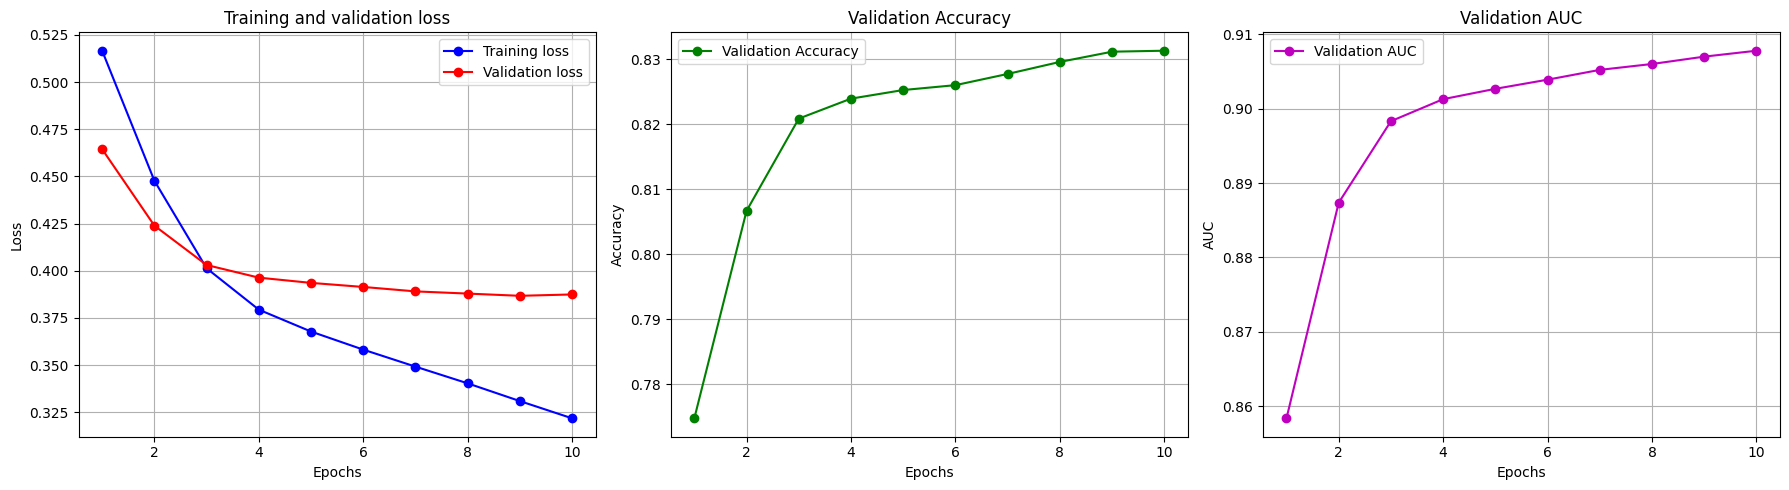

In [7]:
# Trực quan hóa quá trình học
def plot_history_pytorch(history):
  epochs = range(1, len(history['train_loss']) + 1)

  plt.figure(figsize=(18, 5))
  
  # Vẽ đồ thị loss
  plt.subplot(1, 3, 1)
  plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
  plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  
  # Vẽ đồ thị accuracy
  plt.subplot(1, 3, 2)
  plt.plot(epochs, history['val_acc'], 'go-', label='Validation Accuracy')
  plt.title('Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  
  # Vẽ đồ thị AUC
  plt.subplot(1, 3, 3)
  plt.plot(epochs, history['val_auc'], 'mo-', label='Validation AUC')
  plt.title('Validation AUC')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

plot_history_pytorch(history)